# Regression with custom priors

##### Keywords: regression, priors, uninformative priors, MCMC, bayesian, jeffreys prior

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Generate Data

This example is adapted from the pymc3 tutorial

In [3]:
np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

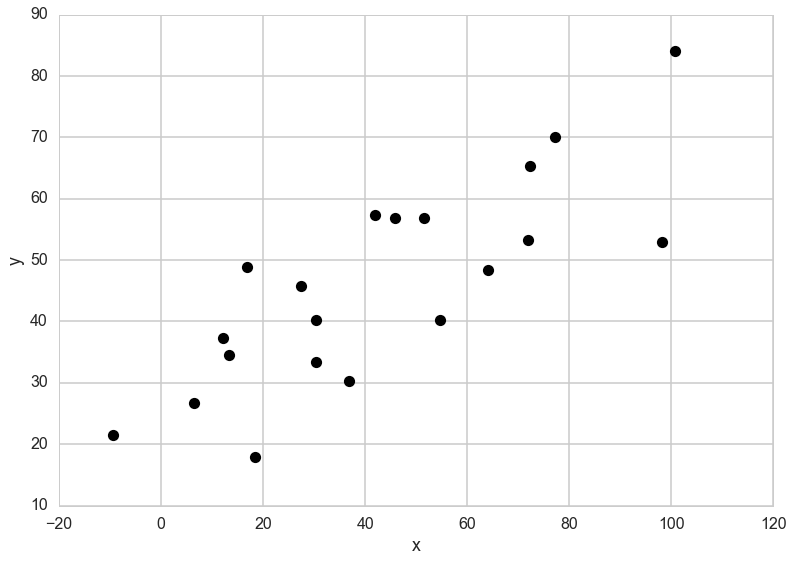

In [4]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

In [2]:
import pymc3 as pm

## Writing the model

$$
\alpha \sim Uniform(-100,100)\\
\beta \sim (1 + \beta^2)^{-3/2}\\
\sigma \sim 1/\sigma \\
\mu = \alpha + \beta x\\
y \sim N(\mu, \sigma)
$$

### Setting priors

Where do the priors for $\sigma$ and $\beta$ come from? The prior for $\sigma$, as we have seen earlier, is the Jeffrey's prior on $\sigma$ the scale parameter for a normal-normal model.

The prior on $\beta$ the slope (remember, we dont want to put a uniform prior on slope) can be derived as an uninformative prior based on symmetry, say:

$$y = \alpha + \beta x ; x = \alpha^{'} + \beta^{'} y$$

Thus $\alpha^{'} = \beta/\alpha$, and $\beta^{'} = 1/\beta$.

The jacobian of the transformation is $\beta^3$ so that $q(\alpha^{'}, \beta^{'}) = \beta^3 p(\alpha, \beta)$ where $q$ is the pdf in the transformed variables. But now we want uninformativeness, or that the transformation should not affect the pdf, and we can check that the prior we chose makes $q=p$ in functional form:

$$p(-\alpha/\beta, 1/\beta) = \beta^3 p(\alpha, \beta)$$

We will need to write custom densities for this. Theano provides us a way:

In [6]:
import theano.tensor as T

with pm.Model() as model1:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities, you must supply logp
    beta = pm.DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * xdata, sd=eps, observed=ydata)

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for sd has negative support for Normal, likely making it unsuitable for this parameter.
  warnings.warn(msg)


## Sampling

And now we sample..

In [12]:
with model1:
    stepper=pm.Metropolis()
    tracem1 = pm.sample(40000, step=stepper)

100%|██████████| 40000/40000 [00:10<00:00, 3952.57it/s] | 405/40000 [00:00<00:09, 4044.57it/s]


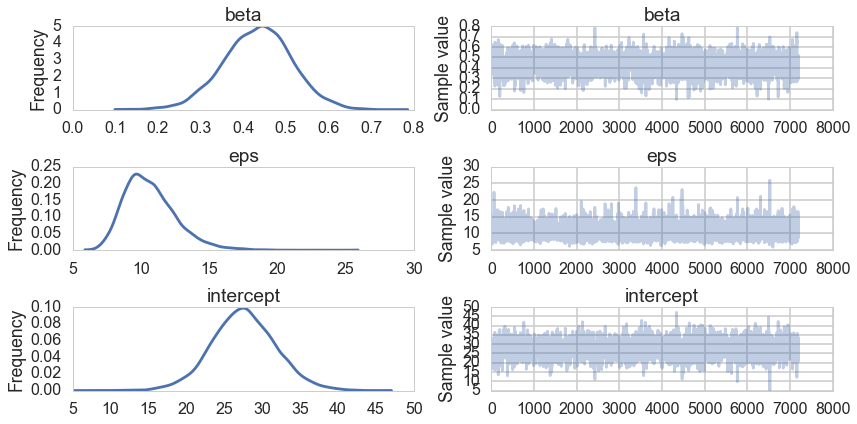

In [15]:
tm1=tracem1[4000::5]
pm.traceplot(tm1);

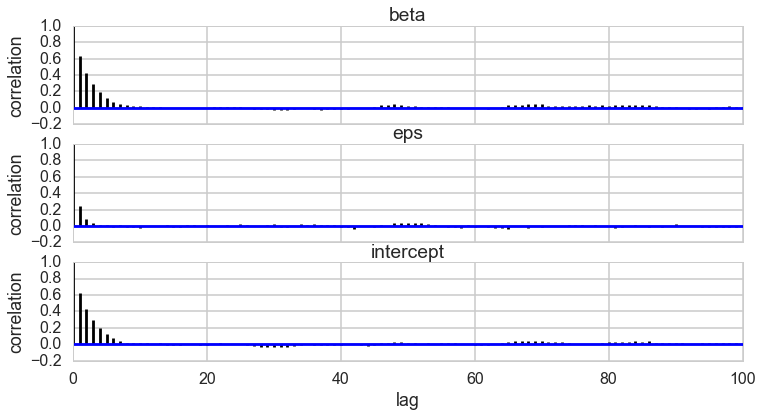

In [16]:
pm.autocorrplot(tm1);

## Results

In [43]:
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model"""
    ax.plot(xdata, ydata, 'ok')

    intercept, beta = trace['intercept'][:,None], trace['beta'][:,None]
    xfit = np.linspace(-20, 120, 10)
    yfit = intercept + beta * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [44]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

In [45]:
def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace['intercept'], trace['beta'])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace['intercept'], trace['beta'], ',k', alpha=0.1)
    ax.set_xlabel(r'intercept')
    ax.set_ylabel(r'$\beta$')

In [46]:
def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

We can plot our posterior contours and see how the posterior reacts to our data.

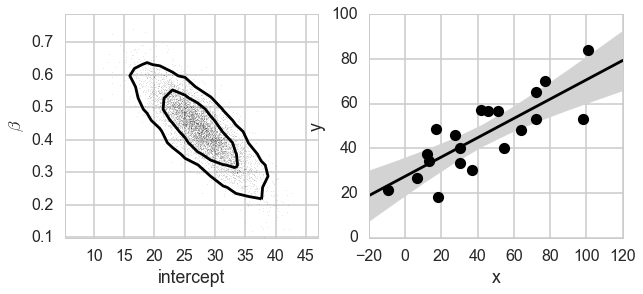

In [47]:
plot_MCMC_results(xdata, ydata, tm1)

### Gewecke convergence test

Our sample-runs give use per-run z scores for the difference of means wau=y within the 1 to -1 bracket.

In [55]:
z=pm.geweke(tm1, intervals=50)

(0, 1000)

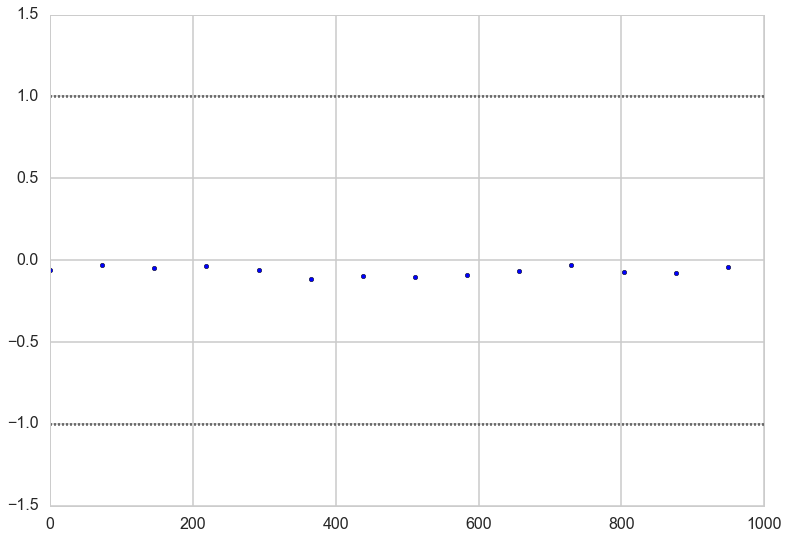

In [56]:
plt.scatter(*z['intercept'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

(0, 1000)

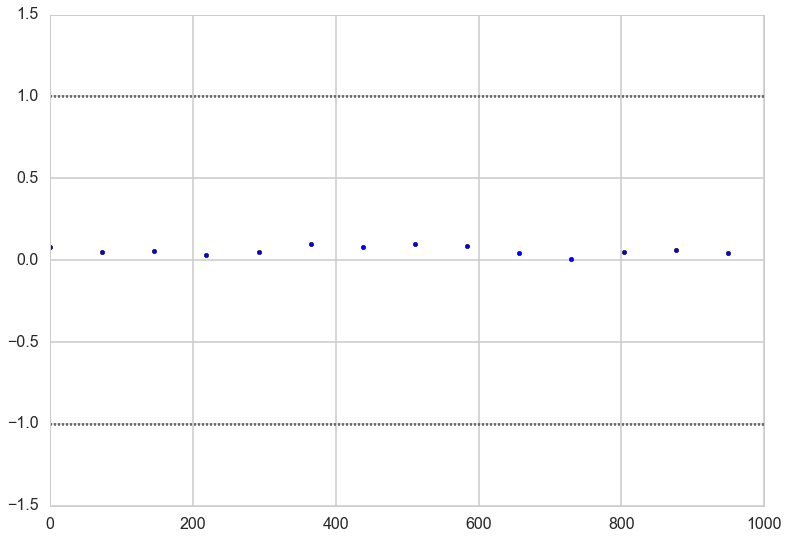

In [57]:
plt.scatter(*z['beta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

(0, 1000)

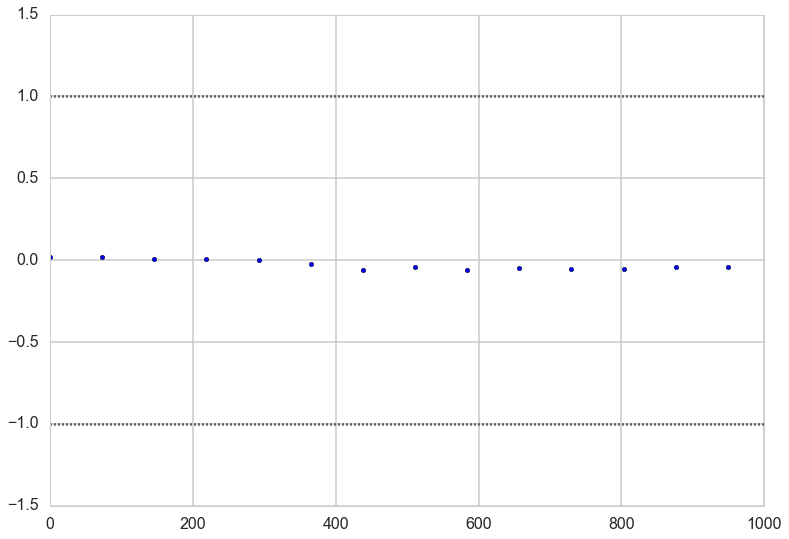

In [58]:
plt.scatter(*z['eps'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

Trying to run multiple chains in this fashion to get Geln-Rubun triggers are bug in python's pickling, so we will have to do this serially for now.

In [60]:
#gelman rubin bug trigger?
with model1:
    stepper=pm.Metropolis()
    tracem2 = pm.sample(40000, step=stepper, njobs=2)

PicklingError: Can't pickle <function <lambda> at 0x118e56840>: attribute lookup <lambda> on __main__ failed